In [2]:
import pandas as pd
import os
from itertools import combinations
from math import comb # Más eficiente para calcular el número de combinaciones
from tqdm import tqdm # Importamos la librería

In [ ]:
class BusquedaExhaustiva:
    def __init__(self, archive, k, m):
        """
        Inicializa el algoritmo de búsqueda exhaustiva.
        
        Args:
            archive (str): Nombre base del archivo de distancias (sin .csv).
            k (int): Número de puntos de suministro a seleccionar en cada solución.
            m (int): Número total de puntos de suministro disponibles.
        """
        # Carga la matriz de distancias
        folder_distances = "./data/distances/demand/"
        route_distances = os.path.join(folder_distances, f"{archive}.csv")

        # --- LÍNEA MODIFICADA ---
        # Usamos index_col=0 para que la primera columna del CSV se trate como el índice de filas.
        # Pandas ya interpreta la primera fila como encabezado por defecto.
        self.df_distances_demand = pd.read_csv(route_distances, index_col=0)
        # -------------------------

        # Prepara el archivo de soluciones finales
        self.route_solutions = "soluciones_finales_2.csv"
        columnas = ["solution", "f1", "f2", "f3"]
        self.df_solutions = pd.DataFrame(columns=columnas)
        
        # Parámetros del problema
        self.k = k
        self.m = m
        
        # Valida que m sea el número de columnas en el df de distancias
        if self.m != len(self.df_distances_demand.columns):
            raise ValueError(
                f"El valor de m ({self.m}) no coincide con el número de columnas "
                f"({len(self.df_distances_demand.columns)}) en el archivo de distancias después de "
                "establecer la primera columna como índice."
            )

    ####
    # F1: Maximizar la mínima distancia cubierta
    ####
    # def f1(self, supply_selected):
    #     """ Minimiza la máxima de las mínimas distancias. """
    #     # .iloc selecciona columnas por su posición entera, lo cual es correcto aquí.
    #     return self.df_distances_demand.iloc[:, supply_selected].min(axis=1).max()
    
    def f1(self, supply_selected):
        """
        Calcula el máximo de las distancias mínimas para cada punto de demanda
        a los puntos de suministro seleccionados, usando operaciones vectorizadas.
        """
        # 1. Selecciona las columnas de la oferta seleccionada.
        # 2. Calcula la distancia mínima para cada fila (axis=1).
        # 3. Devuelve el valor máximo de esas distancias mínimas.
        return self.df_distances_demand.iloc[:, supply_selected].min(axis=1).max()

    ####
    # F2: Equilibrar la carga máxima
    ####
    # def f2(self, supply_selected):
    #     """ Minimiza el número máximo de puntos de demanda asignados a un solo punto de suministro. """
    #     asignacion = self.df_distances_demand.iloc[:, supply_selected].idxmin(axis=1)
    #     if asignacion.empty:
    #         return 0
    #     return asignacion.value_counts().max()
    
    def f2(self, supply_selected):
        asignacion = self.df_distances_demand.iloc[:, supply_selected].idxmin(axis=1)
        maximum = asignacion.value_counts().max()
        return maximum

    ####
    # F3: Equilibrar la carga general
    ####
    # def f3(self, supply_selected):
    #     """ Minimiza la diferencia entre la carga máxima y mínima. """
    #     asignacion = self.df_distances_demand.iloc[:, supply_selected].idxmin(axis=1)
    #     counts = asignacion.value_counts()
    #     if len(counts) <= 1:
    #         return 0
    #     return counts.max() - counts.min()
    
    def f3(self, supply_selected):
        """
        Calcula la diferencia entre el número máximo y mínimo de puntos de demanda
        asignados, asegurando que se consideren todos los puntos de suministro seleccionados.
        """
        # Obtiene los nombres/etiquetas de las columnas seleccionadas
        supply_columns = self.df_distances_demand.columns[supply_selected]
        
        # Determina la asignación de demanda al punto de suministro más cercano
        asignacion = self.df_distances_demand[supply_columns].idxmin(axis=1)
        
        # Cuenta las asignaciones para cada punto de suministro
        counts = asignacion.value_counts()
        
        # Reindexa para incluir todos los puntos de suministro seleccionados,
        # rellenando con 0 los que no recibieron asignaciones.
        all_counts = counts.reindex(supply_columns, fill_value=0)
        
        return all_counts.max() - all_counts.min()

    def _add_solutions(self, solution, f1, f2, f3):
        solution = str(sorted(solution))
        if solution=="[0, 1, 2, 3, 4]":
            print(f'f1: {f1}, f2: {f2}, f3:{f3}')
        if solution=="[1, 2, 3, 4, 5]":
            print(f'f1: {f1}, f2: {f2}, f3:{f3}')
        if solution=="[0, 3, 16, 24, 31]":
            print(f'f1: {f1}, f2: {f2}, f3:{f3}')

        if not self.df_solutions.empty:
            if solution in self.df_solutions["solution"].values:
                print("la solucion ya existe")
                return  # La solución ya existe, no hacer nada

            df_dominado = self.df_solutions.copy()
            df_dominado = df_dominado[df_dominado["f1"] <= f1]
            df_dominado = df_dominado[df_dominado["f2"] <= f2]
            df_dominado = df_dominado[df_dominado["f3"] <= f3]
            if df_dominado.empty:
                # Eliminar soluciones que sean dominadas por la nueva
                self.df_solutions = self.df_solutions[
                    ~(
                        (self.df_solutions["f1"] >= f1)
                        & (self.df_solutions["f2"] >= f2)
                        & (self.df_solutions["f3"] >= f3)
                        & (
                            (self.df_solutions["f1"] > f1)
                            | (self.df_solutions["f2"] > f2)
                            | (self.df_solutions["f3"] > f3)
                        )
                    )
                ]
                # Agregar la nueva solución
                new_solution = pd.DataFrame(
                    [{"solution": solution, "f1": f1, "f2": f2, "f3": f3}]
                )

                self.df_solutions = pd.concat(
                    [self.df_solutions, new_solution], ignore_index=True
                )
                self.df_solutions.to_csv(self.route_solutions, index=False)
        else:
            self.df_solutions = pd.DataFrame(
                [{"solution": solution, "f1": f1, "f2": f2, "f3": f3}]
            )
            self.df_solutions.to_csv(self.route_solutions, index=False)
        return

    def run(self):
        """
        Ejecuta la búsqueda exhaustiva con una barra de progreso.
        """
        print("Iniciando búsqueda exhaustiva...")
        
        potential_supplies = list(range(self.m))
        
        # Calcular el número total de combinaciones de forma eficiente
        num_combinations = comb(self.m, self.k)
        print(f"Se evaluarán {num_combinations} combinaciones. ¡Esto puede tardar mucho tiempo! ⏳")

        all_combinations = combinations(potential_supplies, self.k)
        
        # Envolver el iterador con tqdm para mostrar la barra de progreso
        pbar = tqdm(all_combinations, total=num_combinations, desc="Procesando Combinaciones", unit=" comb")
        
        for current_solution in pbar:
            solution_list = list(current_solution)
            
            # Calcular los tres objetivos
            f1_value = self.f1(solution_list)
            f2_value = self.f2(solution_list)
            f3_value = self.f3(solution_list)

            print((solution_list, f1_value, f2_value, f3_value))
            
            # Añadir al conjunto de Pareto si corresponde
            self._add_solutions(solution_list, f1_value, f2_value, f3_value)
            
            # Opcional: Actualizar la descripción de la barra de progreso con información en tiempo real
            pbar.set_postfix(pareto_count=len(self.df_solutions))

        print(f"\nBúsqueda completada. Se encontraron {len(self.df_solutions)} soluciones no dominadas. ✅")
        print(f"Los resultados se han guardado en '{self.route_solutions}'.")
        print("\nDataFrame final de soluciones de Pareto:")
        print(self.df_solutions)

In [51]:
archive = "WorkSpace 1000_50_5"
k=5
m=50

In [52]:
if __name__ == '__main__':
    # Asegúrate de que la carpeta de datos exista
    if not os.path.exists("./data/distances/demand/"):
        print("Error: La carpeta de datos no existe. Asegúrate de tener la estructura de directorios correcta.")
    else:
        # Aquí debes poner el nombre de tu archivo (sin .csv), k y m correctos
        # ¡CUIDADO! Valores grandes de k y m harán que el programa tarde muchísimo.
        analisis_exhaustivo = BusquedaExhaustiva(archive, k, m)
        analisis_exhaustivo.run()

ValueError: El valor de m (50) no coincide con el número de columnas (51) en el archivo de distancias después de establecer la primera columna como índice.

In [3]:
import numpy as np
import pandas as pd

from tools.compare_functions import load_solutions, get_pareto_front, get_styled_table, classify_solutions
from tools import create_distances
from tools.grasp import Grasp


from tqdm import tqdm
from IPython.display import display, HTML

In [25]:
def guardar_pareto_txt(ruta_csv, ruta_txt):
  """
  Lee un archivo CSV con soluciones de Pareto y guarda los datos de las
  columnas 'f1', 'f2' y 'f30' en un archivo de texto con un formato específico.

  Args:
    ruta_csv (str): La ruta al archivo CSV de entrada.
    ruta_txt (str): La ruta al archivo de texto de salida.
  """
  # Lee el archivo CSV en un DataFrame de pandas
  df = pd.read_csv(ruta_csv)

  # Abre el archivo de texto en modo de escritura
  with open(ruta_txt, 'w') as f:
    # Itera sobre cada fila del DataFrame
    for _, fila in df.iterrows():
      # Extrae y redondea los valores de las columnas
      f1 = fila['f1']
      f2 = fila['f2']
      f3 = fila['f3'] # Se ajusta el valor de f30

      # Escribe los valores formateados en el archivo de texto
      f.write(f"{f1}\t{f2}\t{f3}\n")

# Ejemplo de uso de la función
guardar_pareto_txt('soluciones_finales_2.csv', 'soluciones_finales_2.txt')

print("¡El archivo 'pareto_formateado.txt' ha sido creado con éxito!")

¡El archivo 'pareto_formateado.txt' ha sido creado con éxito!


# Soluciones exhaustivas vs frente de pareto previo

In [5]:
# Carga
ruta_solution="soluciones_finales.csv"
ruta_pareto="./Pareto_front_paper/"+archive+".txt"
df_csv_full, df_csv_obj, df_txt = load_solutions(ruta_solution, ruta_pareto)

In [6]:
# Unir y encontrar frente de Pareto
all_solutions = np.vstack([df_csv_obj.values, df_txt.values])
pareto_mask = get_pareto_front(all_solutions)
pareto_solutions = all_solutions[pareto_mask]

# Arrays para detección de comunes
csv_array = df_csv_obj.values
txt_array = df_txt.values

# Clasificar
colors_csv = classify_solutions(df_csv_obj, pareto_solutions, txt_array)
colors_txt = classify_solutions(df_txt, pareto_solutions, csv_array)

# Mostrar
html_csv = get_styled_table(df_csv_full, colors_csv)
html_txt = get_styled_table(df_txt, colors_txt)

# Mostrar lado a lado con HTML
display(HTML(f"""
<div style="display: flex; gap: 30px;">
  <div style="flex: 1;">
    <h3>Soluciones CSV (con ID)</h3>
    {html_csv}
  </div>
  <div style="flex: 1;">
    <h3>Soluciones TXT</h3>
    {html_txt}
  </div>
</div>
"""))


,solution,f1,f2,f3
0,"[1, 4, 14, 27, 29]",379.969736,259,160
1,"[2, 8, 11, 27, 29]",481.133038,203,6
2,"[2, 17, 19, 23, 29]",458.802790,209,22
3,"[3, 7, 12, 27, 29]",442.764046,229,104
4,"[3, 9, 12, 27, 29]",442.764046,233,103
5,"[3, 9, 13, 27, 29]",433.416659,243,113
6,"[3, 10, 15, 27, 30]",441.834811,241,125
7,"[3, 12, 15, 27, 30]",450.699456,227,83
8,"[4, 14, 27, 29, 46]",377.005305,281,210
9,"[4, 14, 27, 29, 47]",377.005305,284,202


# Soluciones extraidas vs soluciones exactas

In [26]:
# Carga
ruta_solution="Solutions/"+archive+".csv"
ruta_pareto="soluciones_finales_2.txt"
df_csv_full, df_csv_obj, df_txt = load_solutions(ruta_solution, ruta_pareto)

In [27]:
# Unir y encontrar frente de Pareto
all_solutions = np.vstack([df_csv_obj.values, df_txt.values])
pareto_mask = get_pareto_front(all_solutions)
pareto_solutions = all_solutions[pareto_mask]

# Arrays para detección de comunes
csv_array = df_csv_obj.values
txt_array = df_txt.values

# Clasificar
colors_csv = classify_solutions(df_csv_obj, pareto_solutions, txt_array)
colors_txt = classify_solutions(df_txt, pareto_solutions, csv_array)

# Mostrar
html_csv = get_styled_table(df_csv_full, colors_csv)
html_txt = get_styled_table(df_txt, colors_txt)

# Mostrar lado a lado con HTML
display(HTML(f"""
<div style="display: flex; gap: 30px;">
  <div style="flex: 1;">
    <h3>Soluciones CSV (con ID)</h3>
    {html_csv}
  </div>
  <div style="flex: 1;">
    <h3>Soluciones TXT</h3>
    {html_txt}
  </div>
</div>
"""))


,solution,f1,f2,f3
0,"[0, 3, 16, 24, 31]",427.023419,247,103
1,"[3, 18, 20, 24, 30]",458.802790,209,22
2,"[5, 15, 28, 30, 47]",377.005305,281,210
3,"[0, 6, 14, 24, 36]",457.106115,218,40
4,"[4, 8, 13, 28, 30]",442.764046,229,104
5,"[3, 9, 12, 28, 30]",481.133038,203,6
6,"[4, 10, 13, 28, 30]",442.764046,233,103
7,"[2, 5, 14, 28, 30]",412.506970,262,163
8,"[4, 8, 14, 24, 30]",433.416659,239,139
9,"[2, 5, 17, 28, 30]",379.969736,271,172


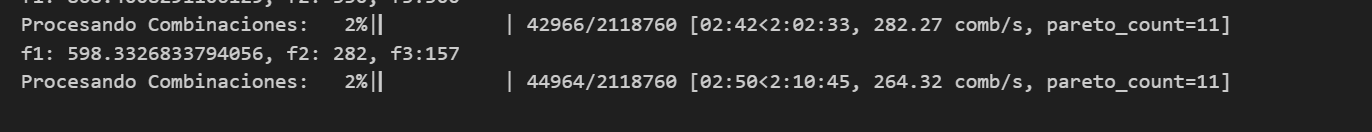

In [47]:
from tools.objective_functions import max_min_dist, max_supply_demanded, balanced_supply_demanded

In [54]:
df_distances_demand=pd.read_csv("./data/distances/demand/"+archive+".csv", index_col=0)

In [55]:
supply_selected=[0, 1, 2, 3, 7]

In [56]:
df_distances_demand.iloc[:, supply_selected]

,0,1,2,3,7
0,129.251692,500.225949,788.915712,1081.566457,385.861374
1,165.604952,535.631403,824.510158,1117.302555,411.254179
2,150.472589,545.265073,830.426396,1120.914805,461.736938
3,84.005952,477.150920,763.062907,1054.110526,398.848342
4,184.141250,569.835064,857.779692,1149.895647,458.755926
...,...,...,...,...,...
995,95.257546,427.094837,716.100552,1009.040138,312.507600
996,214.443466,565.390131,854.189674,1147.192225,416.635332
997,184.835062,495.176736,782.796270,1075.458972,335.769266
998,134.272112,494.292424,783.255386,1076.134285,371.682660


In [40]:
def f1(df_distances_demand, supply_selected):
        """
        Calcula el máximo de las distancias mínimas para cada punto de demanda
        a los puntos de suministro seleccionados, usando operaciones vectorizadas.
        """
        # 1. Selecciona las columnas de la oferta seleccionada.
        # 2. Calcula la distancia mínima para cada fila (axis=1).
        # 3. Devuelve el valor máximo de esas distancias mínimas.
        return df_distances_demand.iloc[:, supply_selected].min(axis=1).max()

In [45]:
f1(df_distances_demand, supply_selected)

np.float64(868.4008291106129)

In [49]:
a=max_min_dist(df_distances_demand, supply_selected)
b=max_supply_demanded(df_distances_demand, supply_selected)
c=balanced_supply_demanded(df_distances_demand, supply_selected)
print(a,b,c)

868.4008291106129 347 267
